In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import copy
from scipy import stats
from random import choice
from itertools import izip_longest
from networkx.algorithms import approximation

from IPython.display import display

In [2]:
### UNCOMMENT FOR PREPROCESSING
# with open("data.csv", "r") as infile, open("processed.csv", "w") as outfile:
#     for line in infile:
#         splited = line.split(',')[3]
#         outfile.write(splited.upper())
#         outfile.write('\n')


In [3]:
G = nx.Graph()
with open("processed.csv", "r") as infile:
    for k, line in enumerate(infile):
        splited = list(map(str.strip, line.split('&')))
        for i in range(len(splited)):
            G.add_node(splited[i])
            for j in range(i+1, len(splited)):
                G.add_edge(splited[i], splited[j])


## A partir del archivo de datos, genere el grafo de colaboraciones entre autores. Cuente el número de nodos y aristas. Haga una representación gráfica del grafo

Mostramos el subgrafo compuesto por los 100 nodos de mayor grado

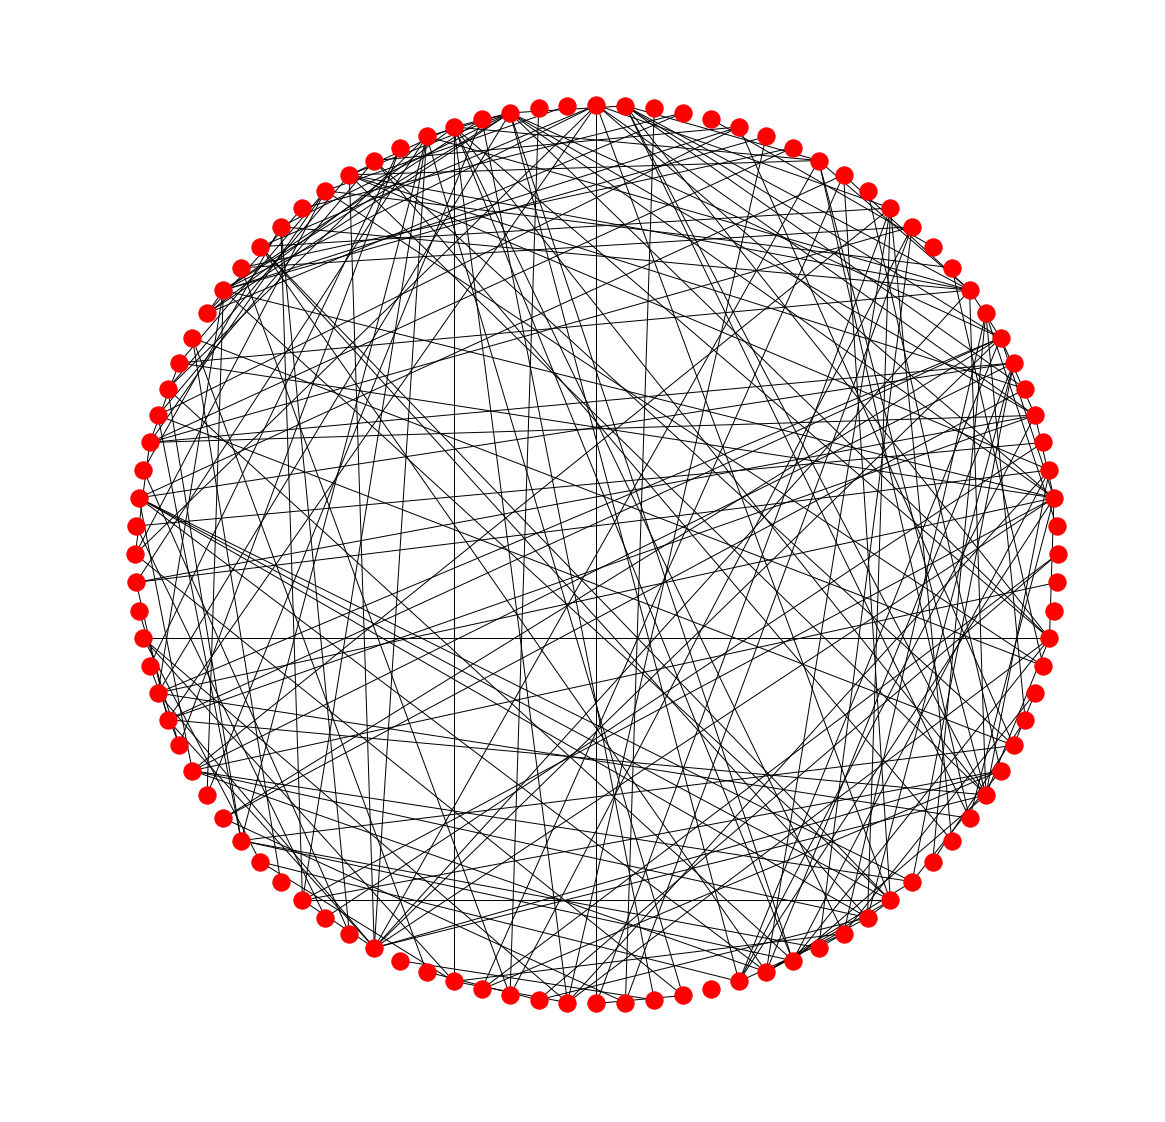

Número de nodos: 3959
Número de aristas: 7920


In [4]:
plt.subplots(figsize=(20,20))
number_of_samples = 100

degree_sequence = sorted([(n[1], n[0]) for n in nx.degree(G)], reverse=True)

# i = 0
# sample = []
# while i < len(degree_sequence) and len(sample) < number_of_samples:
#     if np.random.choice([0,1], p=[0.8, 0.2]) == 1:
#         sample.append(degree_sequence[i][1])
#     i+=1
sample = [n[1] for i, n in enumerate(degree_sequence) if i < number_of_samples]

GAux = nx.subgraph(G, sample)
nx.draw_shell(GAux)

plt.show()

print 'Número de nodos:', nx.number_of_nodes(G)
print 'Número de aristas:', nx.number_of_edges(G)


## Grafique la distribución del grado de los autores, en escalas lineales, semilogarítmica, y log-log

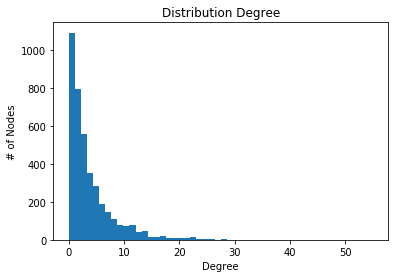

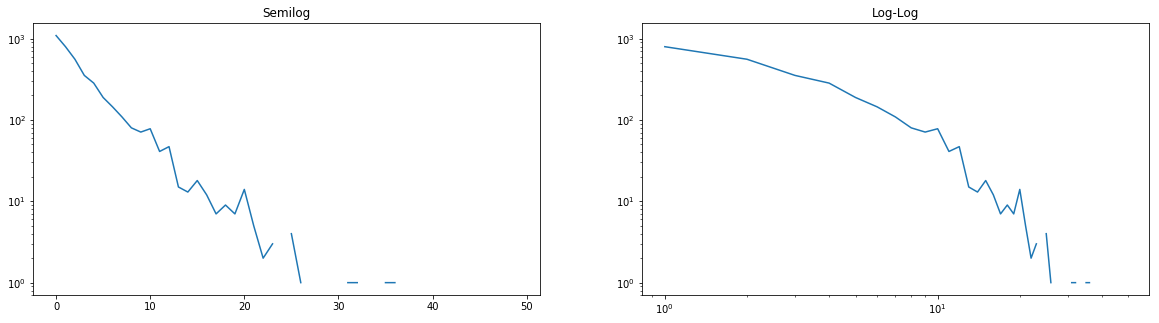

In [5]:
bins = 50
plt.hist([n[0] for n in degree_sequence], bins=bins)
plt.title('Distribution Degree')
plt.xlabel('Degree')
plt.ylabel('# of Nodes')
plt.show()

_, axs = plt.subplots(1, 2, figsize = (20, 5))

h , b = np.histogram([n[0] for n in degree_sequence], bins=bins)
axs[0].semilogy(h)
axs[0].set_title('Semilog')
axs[1].loglog(h)
axs[1].set_title('Log-Log')
plt.show()


### Argumente, a partir de los gráficos, de qué tipo de distribución se trata

Dado que el gráfico con escala Semilog muestra una tendencia lineal, podemos concluir que la distribución de grado del Grafo, es exponencial.

## Calcule el número de componentes conexas del grafo. Muestre el tamaño de la componente mayor, o componente gigante

In [6]:
connected_components = nx.connected_component_subgraphs(G)

graphs = list(connected_components)
print 'Número de componentes conexas:', len(graphs)
max_component = max(graphs, key=len)
print 'Tamaño de la componente gigante:', nx.number_of_nodes(max_component)


Número de componentes conexas: 506
Tamaño de la componente gigante: 3041


## Trabajando con la componente gigante del grafo, estudie, parándose en un nodo al azar, cómo aumenta el número de autores alcanzados a medida que se aleja del nodo semilla

In [7]:
acum_new_nodes = []
sum_new_nodes_per_level = []
trials = 1
for _ in range(trials):
    trial_acum_new_nodes = [1]
    new_nodes_per_level = []
    
    random_node = random.choice(list(max_component.nodes()))
    visited = { random_node }
    current_level_nodes = { random_node }
    next_level_nodes = set()

    while current_level_nodes:
        for node in current_level_nodes:
            neighbors = max_component.neighbors(node)
            for neighbor in neighbors:
                if neighbor not in visited:
                    visited.add(neighbor)
                    next_level_nodes.add(neighbor)

        new_nodes_per_level.append(len(next_level_nodes))
        trial_acum_new_nodes.append(trial_acum_new_nodes[-1] + len(next_level_nodes))
        current_level_nodes = next_level_nodes
        next_level_nodes = set()

    sum_new_nodes_per_level = [sum(n) for n in izip_longest(sum_new_nodes_per_level, new_nodes_per_level, fillvalue=0)]
    acum_new_nodes = [sum(n) for n in izip_longest(acum_new_nodes, trial_acum_new_nodes, fillvalue=0)]

mean_new_nodes_per_level = list(map(lambda x: x/trials, sum_new_nodes_per_level))
mean_acum_new_nodes = list(map(lambda x: x/trials, acum_new_nodes))


### Grafique el número de autores alcanzados en función de la distancia al nodo semilla

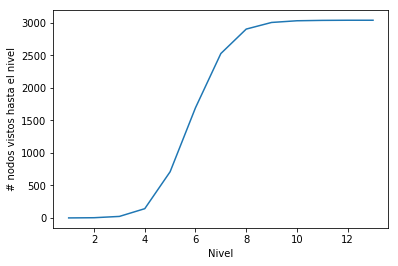

In [8]:
plt.plot(list(range(1,len(mean_acum_new_nodes)+1)), mean_acum_new_nodes)
plt.xlabel('Nivel')
plt.ylabel('# nodos vistos hasta el nivel')
plt.show()


### Grafique también el número de nuevos autores que se agregan en cada paso, y estime el máximo de esta función

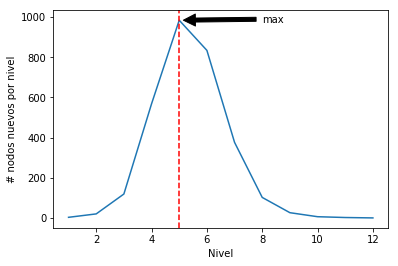

In [9]:
plt.plot(list(range(1,len(mean_new_nodes_per_level)+1)), mean_new_nodes_per_level)

max_y = max(mean_new_nodes_per_level)
max_x = mean_new_nodes_per_level.index(max_y) + 1
plt.annotate('max', xy=(max_x, max_y), xytext=(max_x + 3, max_y * 0.99),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.axvline(x=max_x, color='red', linestyle='--')
plt.xlabel('Nivel')
plt.ylabel('# nodos nuevos por nivel')

plt.show()


### Pruebe con varios nodos semillas y analice la robustez de este resultado

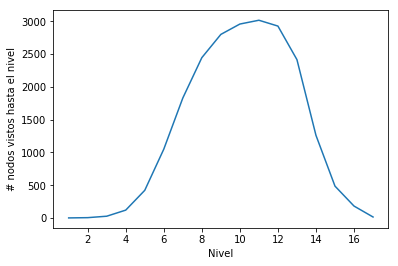

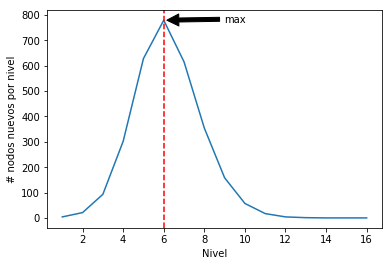

In [10]:
acum_new_nodes = []
sum_new_nodes_per_level = []
trials = 200
for _ in range(trials):
    trial_acum_new_nodes = [1]
    new_nodes_per_level = []
    
    random_node = random.choice(list(max_component.nodes()))
    visited = { random_node }
    current_level_nodes = { random_node }
    next_level_nodes = set()

    while current_level_nodes:
        for node in current_level_nodes:
            neighbors = max_component.neighbors(node)
            for neighbor in neighbors:
                if neighbor not in visited:
                    visited.add(neighbor)
                    next_level_nodes.add(neighbor)

        new_nodes_per_level.append(len(next_level_nodes))
        trial_acum_new_nodes.append(trial_acum_new_nodes[-1] + len(next_level_nodes))
        current_level_nodes = next_level_nodes
        next_level_nodes = set()

    sum_new_nodes_per_level = [sum(n) for n in izip_longest(sum_new_nodes_per_level, new_nodes_per_level, fillvalue=0)]
    acum_new_nodes = [sum(n) for n in izip_longest(acum_new_nodes, trial_acum_new_nodes, fillvalue=0)]

mean_new_nodes_per_level = list(map(lambda x: x/trials, sum_new_nodes_per_level))
mean_acum_new_nodes = list(map(lambda x: x/trials, acum_new_nodes))

plt.plot(list(range(1,len(mean_acum_new_nodes)+1)), mean_acum_new_nodes)
plt.xlabel('Nivel')
plt.ylabel('# nodos vistos hasta el nivel')
plt.show()

plt.plot(list(range(1,len(mean_new_nodes_per_level)+1)), mean_new_nodes_per_level)

max_y = max(mean_new_nodes_per_level)
max_x = mean_new_nodes_per_level.index(max_y) + 1
plt.annotate('max', xy=(max_x, max_y), xytext=(max_x + 3, max_y * 0.99),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.axvline(x=max_x, color='red', linestyle='--')
plt.xlabel('Nivel')
plt.ylabel('# nodos nuevos por nivel')

plt.show()


### Discuta el significado de los gráficos y su relación con el fenómeno de seis grados de separación

En el primer gráfico podemos observar cómo crece la cantidad de nodos vistos a medida que nos alejamos del nodo semilla, hasta haber visto todos los nodos de la componente gigante. Este gráfico es creciente, y se puede ver cómo a partir de los seis grados de separación al nodo semilla, la cantidad de nodos aumenta exponencialmente. 

En el caso de este primer gráfico para el promedio (tomando distintos nodos semilla y promediando), a partir de la distancia 11 hay un decrecimiento porque, para algunos nodos semilla, la distancia promedio a los otros nodos del grafo será mayor que para otros. Es decir, para algunos nodos con 11 iteraciones bastará para ver todo el grafo, pero para otros serán necesarias más. 

El segundo gráfico muestra cuántos nodos nuevos se ven por cada iteración. En ambos casos (eligiendo un nodo al azar, o promediando varios elegidos al azar), la máxima cantidad de nuevos nodos se alcanza al alejarse seis niveles del nodo semilla.

En relación al fenómeno de seis grados de separación, viendo el primer gráfico podemos concluir que al alejarnos seis niveles del nodo semilla, ya hemos visto la mitad de los nodos del grafo. A su vez, viendo el segundo, podemos ver que en ese mismo momento, alcanzamos una "explosión" de nodos nuevos: a partir de los siguientes niveles, la cantidad de nuevos nodos disminuye.

## Compute el coeficiente de clustering C y el camino mínimo medio l para la componente gigante

In [11]:
avg_clustering = approximation.clustering_coefficient.average_clustering(max_component)

avg_shortest_path = nx.algorithms.shortest_paths.generic.average_shortest_path_length(max_component)

print avg_clustering, avg_shortest_path


0.501 6.07115496115


### Genere un grafo aleatorio con la misma distribución de grado y compute las mismas medidas para este grafo

Observación: Para poder realizar el experimento, necesitamos que el grafo generado sea conexo, lo cual no está garantizado por el generador de grafos. Para conseguir esta propiedad decidimos unir cada componente conexa agregando un eje entre nodos al azar de cada componente conexa. Esto no debería modificar en forma significativa la distribución de grado.

In [12]:
degree_sequence_max_component = [n[1] for n in nx.degree(max_component)]

random_graph = nx.generators.degree_seq.random_degree_sequence_graph(degree_sequence_max_component)
connected_components_random_graph = list(nx.connected_component_subgraphs(random_graph))
for i, _ in enumerate(connected_components_random_graph):
    if i > 0:
        random_node_i = random.choice(list(connected_components_random_graph[i].nodes()))
        random_node_j = random.choice(list(connected_components_random_graph[i-1].nodes()))
        random_graph.add_edge(random_node_i, random_node_j)


Kolgomorov-Smirnov p-value: 1.0


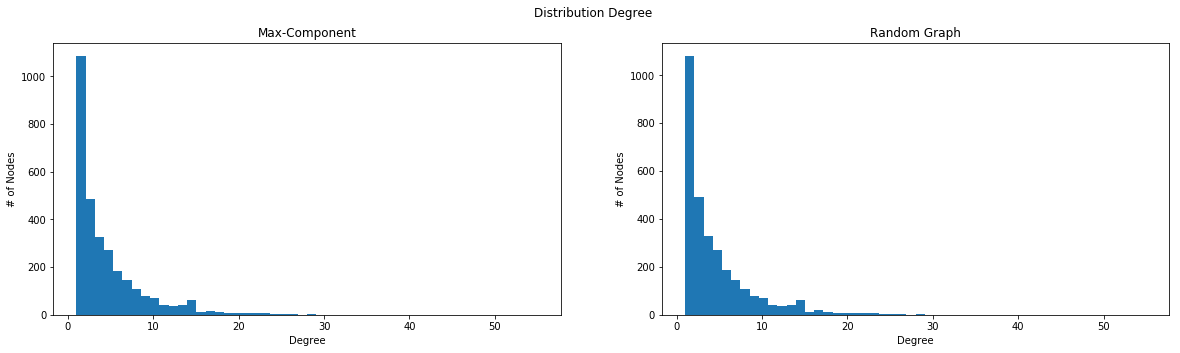

In [16]:
degree_sequence_random = sorted([n[1] for n in nx.degree(random_graph)], reverse=True)

print 'Kolgomorov-Smirnov p-value:', stats.ks_2samp(degree_sequence_random, degree_sequence_max_component)[1]

_, axs = plt.subplots(1, 2, figsize = (20, 5))

axs[0].hist(degree_sequence_max_component, bins=bins)
axs[0].set_title('Max-Component')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('# of Nodes')
axs[1].hist(degree_sequence_random, bins=bins)
axs[1].set_title('Random Graph')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('# of Nodes')

plt.suptitle('Distribution Degree')
plt.show()


Habiendo corrido el test de Kolgomorov-Smirnov, no podemos decir que las muestras provengan de diferentes distribuciones. Además, viendo los gráficos podemos observar que, efectivamente, la distribucion de grado del grafo aleatorio se corresponde con el del grafo original a pesar de haberle agregado ejes para hacerlo conexo.

In [17]:
random_graph_avg_clustering = approximation.clustering_coefficient.average_clustering(random_graph)
random_graph_avg_shortest_path = nx.algorithms.shortest_paths.generic.average_shortest_path_length(random_graph)

print random_graph_avg_clustering, random_graph_avg_shortest_path


0.006 4.76766623687


### Compare e interprete los resultados. ¿Se trata de un grafo con estructura de mundos pequeños?

En el primer caso, analizando la componente gigante, podemos concluir que se trata de un grafo con estructura de mundos pequeños, pues el coeficiente de clustering es relativamente alto y el largo del camino mínimo medio resulta ser bajo para la cantidad de nodos de la componente.

En el caso del grafo aleatorio con distribución de grado similar a la de nuestro grafo testigo, vemos que el coeficiente de clustering es extremadamente bajo y esto produce un largo de camino mínimo medio aún más bajo, por lo que podemos concluir que no tiene estructura de mundos pequeños.

## Discuta cómo haría para individuar a los autores "estrella" del campo

Vamos a utilizar medidas de centralidad, dado que nos dan información acerca de que tan importante es un nodo en una red:
* Betweennes
* Degree
* Closeness

### Evalúe quiénes son estos autores según por lo menos dos métricas diferentes. Analice qué sucedería con la comunidad si estos autores desapareciesen. En particular, determine cuántos autores deberían desaparecer para que desaparezca la componente gigante del grafo

In [15]:
def estrellas(centrality, max_component_aux):
    ordered_list = sorted(centrality, key = centrality.get, reverse = True)
    print 'Autores centrales: ', ordered_list[:10]

    max_len = len(ordered_list)

    max_component_copy = copy.deepcopy(max_component_aux)
    while nx.is_connected(max_component_copy):
        max_component_copy.remove_node(ordered_list.pop(0))

    print 'Nodos eliminados:', max_len - len(ordered_list)
    print 'Número de componentes conexas', len(list(nx.connected_components(max_component_copy)))


In [16]:
degree_centrality = nx.degree_centrality(max_component)
betweennes_centrality = nx.betweenness_centrality(max_component)
closeness_centrality = nx.closeness_centrality(max_component)


In [17]:
estrellas(betweennes_centrality, max_component)


Autores centrales:  ['LEE', 'VAFA', 'KIM', 'AMBJORN', 'KOGAN', 'PARK', 'OHTA', 'GIBBONS', 'FERRARA', 'TOWNSEND']
Nodos eliminados: 1
Número de componentes conexas 5


In [18]:
estrellas(degree_centrality, max_component)


Autores centrales:  ['LEE', 'AMBJORN', 'PARK', 'KIM', 'FERRARA', 'VAFA', 'STROMINGER', 'LU', 'POPE', 'ODINTSOV']
Nodos eliminados: 1
Número de componentes conexas 5


In [19]:
estrellas(closeness_centrality, max_component)


Autores centrales:  ['LEE', 'VAFA', 'STROMINGER', 'PARK', 'FERRARA', 'KIM', 'LU', 'GIBBONS', 'POLCHINSKI', 'LOWE']
Nodos eliminados: 1
Número de componentes conexas 5


Este experimento no nos dice mucho, pues para las 3 medidas vamos a quitar el nodo más central y este ya va a dejar nodos aislados. Por lo tanto proponemos analizar qué sucede con la siguiente componente gigante al eliminar iterativamente los nodos mas centrales, sin modificar los calculos de centralidad del grafo original.

Vamos a considerar que la componente gigante "desapareció" cuando se reduzca a 1/4 de su tamaño original.

In [20]:
def estrellas_v2(centrality, max_component_aux):
    ordered_list = sorted(centrality, key = centrality.get, reverse = True)

    max_component_copy = copy.deepcopy(max_component_aux)
    max_len = len(list(max_component_copy.nodes()))
    current_len = max_len

    lens = [max_len]

    while max_len / 4 < current_len:
        actual_node = ordered_list.pop(0)
        if actual_node in max_component_copy.nodes():
            max_component_copy.remove_node(actual_node)
            max_component_copy = max(list(nx.connected_component_subgraphs(max_component_copy)), key=len)
            current_len = len(list(max_component_copy.nodes()))
            lens.append(current_len)

    plt.plot(lens)
    plt.xlabel('# estrellas removidas')
    plt.ylabel('# nodos de la componente gigante')
    plt.show()


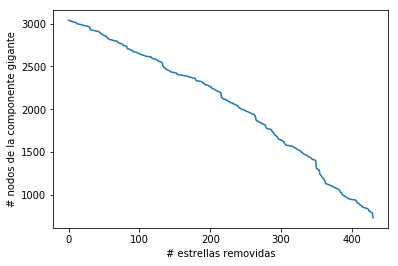

In [21]:
estrellas_v2(betweennes_centrality, max_component)


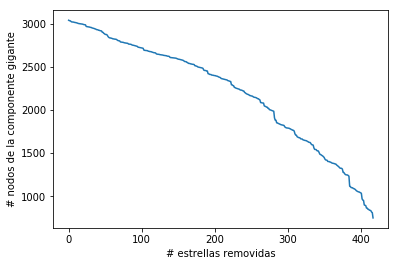

In [22]:
estrellas_v2(degree_centrality, max_component)


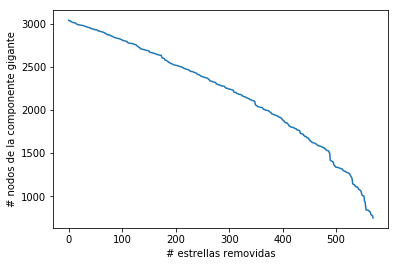

In [23]:
estrellas_v2(closeness_centrality, max_component)


Podemos ver que, para todas las medidas de centralidad, la cantidad de nodos disminuye de manera similar y linealmente (lenta), con lo cual podemos concluir que el grafo es muy robusto, ya que quitar un nodo muy central no significa perder una gran cantidad de conexiones.